In [428]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [429]:
marketing = pd.read_csv('Data/Cust_Records.csv')
marketing.columns

Index(['Age', 'Education', 'Relationship_Status', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases',
       'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases',
       'Days_Enrolled', 'Avg_Purch_Freq', 'Avg_Spend ($)', 'Accept_One',
       'Accept_Rate', 'Cust_Accept (%)'],
      dtype='object')

In [430]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2223 entries, 0 to 2222
Data columns (total 22 columns):
Age                    2223 non-null int64
Education              2223 non-null object
Relationship_Status    2223 non-null object
Income                 2223 non-null float64
Children               2223 non-null int64
Wine ($)               2223 non-null int64
Fruit ($)              2223 non-null int64
Meat ($)               2223 non-null int64
Fish ($)               2223 non-null int64
Sweets ($)             2223 non-null int64
Gold_Products ($)      2223 non-null int64
Total Spent ($)        2223 non-null int64
Discount_Purchases     2223 non-null int64
Web_Purchases          2223 non-null int64
Catalog_Purchases      2223 non-null int64
Store_Purchases        2223 non-null int64
Days_Enrolled          2223 non-null float64
Avg_Purch_Freq         2223 non-null float64
Avg_Spend ($)          2223 non-null float64
Accept_One             2223 non-null int64
Accept_Rate            

**Preprocessing for Customer Segmentation / Classification Below**

In [431]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

marketing_ml = marketing.drop(['Accept_One', 'Accept_Rate', 'Cust_Accept (%)'], axis=1)

## Unskewing Data with Log(1 + x) transform ###
unskewed = marketing_ml[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)']]
unskewed = np.log1p(unskewed)
unskewed = pd.DataFrame(unskewed)

### Scaling Numerical Features ###
scaler = StandardScaler()
numerical = scaler.fit_transform(unskewed)
numerical = pd.DataFrame(numerical)

### Numerically Encoding Categorical Features ###
categorical = pd.get_dummies(data=marketing_ml, columns=['Education', 'Relationship_Status'], drop_first=False)

### Appending the categorical features to end on unskewed DF ###
ml = numerical.join(categorical[['Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']])
ml.columns = ['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']

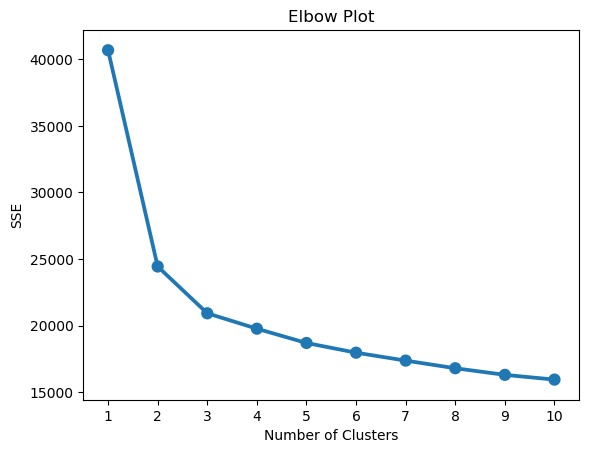

3 clusters looks optimal


In [432]:
from sklearn.cluster import KMeans
import seaborn as sns


X = ml
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=27)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Elbow Plot')
plt.show()
print('3 clusters looks optimal')

In [433]:
customer_clusters = pd.DataFrame(marketing[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)', 'Accept_One', 'Cust_Accept (%)']])
### Frequency ###
kmeans = KMeans(n_clusters = 3)
kmeans.fit(ml[['Avg_Purch_Freq']])
customer_clusters['FrequencyCluster'] = kmeans.predict(ml[['Avg_Purch_Freq']])
freq = customer_clusters.groupby('FrequencyCluster')[['Avg_Purch_Freq']].mean().sort_values('Avg_Purch_Freq', ascending=True).reset_index(drop=False)
# freq['FrequencyCluster'] = freq.index
freq


,FrequencyCluster,Avg_Purch_Freq
0,2,13.298030
1,0,32.766383
2,1,95.691760


In [434]:
## Value of each visit ###
kmeans = KMeans(n_clusters = 3)
kmeans.fit(ml[['Avg_Spend ($)']])
customer_clusters['SpendCluster'] = kmeans.labels_
spend = customer_clusters.groupby('SpendCluster')[['Avg_Spend ($)']].mean().sort_values('Avg_Spend ($)', ascending=False).reset_index(drop=False)
# spend['SpendCluster'] = spend.index
spend

,SpendCluster,Avg_Spend ($)
0,2,72.718259
1,1,26.706727
2,0,7.742417


In [435]:
### Total Revenue ###
kmeans = KMeans(n_clusters = 3)
kmeans.fit(ml[['Total Spent ($)']])
customer_clusters['RevenueCluster'] = kmeans.labels_
revenue = customer_clusters.groupby('RevenueCluster')[['Total Spent ($)']].mean().sort_values('Total Spent ($)', ascending=False).reset_index(drop=False)
# revenue['RevenueCluster'] = revenue.index
revenue

,RevenueCluster,Total Spent ($)
0,0,1207.000000
1,1,300.275605
2,2,50.792350


In [436]:
### Reassigning Cluster Values Before Giving Overall Score to Customers ###
for idx, row in customer_clusters.iterrows():
    if row['FrequencyCluster'] == freq.loc[0, 'FrequencyCluster']:
        customer_clusters.loc[idx, 'FrequencyCluster'] = 0
    elif row['FrequencyCluster'] == freq.loc[1, 'FrequencyCluster']:
        customer_clusters.loc[idx, 'FrequencyCluster'] = 1
    elif row['FrequencyCluster'] == freq.loc[2, 'FrequencyCluster']:
        customer_clusters.loc[idx, 'FrequencyCluster'] = 2
    if row['SpendCluster'] == spend.loc[0, 'SpendCluster']:
        customer_clusters.loc[idx, 'SpendCluster'] = 0
    elif row['SpendCluster'] == spend.loc[1, 'SpendCluster']:
        customer_clusters.loc[idx, 'SpendCluster'] = 1
    elif row['SpendCluster'] == spend.loc[2, 'SpendCluster']:
        customer_clusters.loc[idx, 'SpendCluster'] = 2
    if row['RevenueCluster'] == revenue.loc[0, 'RevenueCluster']:
        customer_clusters.loc[idx, 'RevenueCluster'] = 0
    elif row['RevenueCluster'] == revenue.loc[1, 'RevenueCluster']:
        customer_clusters.loc[idx, 'RevenueCluster'] = 1
    elif row['RevenueCluster'] == revenue.loc[2, 'RevenueCluster']:
        customer_clusters.loc[idx, 'RevenueCluster'] = 2

### Calculating Each Customer's Overall Score ###
customer_clusters['Overall_Score'] = customer_clusters['FrequencyCluster'] + customer_clusters['SpendCluster'] + customer_clusters['RevenueCluster']
customer_clusters = customer_clusters.drop(['FrequencyCluster', 'SpendCluster', 'RevenueCluster'], axis=1)
customer_clusters.groupby('Overall_Score')['Avg_Purch_Freq', 'Avg_Spend ($)', 'Total Spent ($)', 'Accept_One', 'Cust_Accept (%)'].mean()

,Avg_Purch_Freq,Avg_Spend ($),Total Spent ($),Accept_One,Cust_Accept (%)
Overall_Score,,,,,
0,13.343896,71.361338,1491.189655,0.543103,19.827586
1,24.614077,59.948763,1229.366038,0.432075,12.201258
2,23.874236,31.576853,647.880399,0.245847,6.201550
3,34.348246,21.663726,326.226351,0.206081,4.391892
4,53.190389,15.467461,161.870748,0.149660,2.947846
5,44.271082,8.686060,63.444444,0.139918,3.086420
6,101.367517,7.332449,45.567511,0.122363,2.496484


In [437]:
### Assigning Customer Value Groups ###
customer_clusters['Customer_Value'] = ''
for idx, row in customer_clusters.iterrows():
    if row['Overall_Score'] == 0 or row['Overall_Score'] == 1:
        customer_clusters.loc[idx, 'Customer_Value'] = 'High'
    if row['Overall_Score'] == 2 or row['Overall_Score'] == 3:
        customer_clusters.loc[idx, 'Customer_Value'] = 'Medium'
    if row['Overall_Score'] == 4 or row['Overall_Score'] == 5 or row['Overall_Score'] == 6:
        customer_clusters.loc[idx, 'Customer_Value'] = 'Low'
customer_clusters.drop('Overall_Score', axis=1)
print(customer_clusters['Customer_Value'].value_counts())

Low       864
High      762
Medium    597
Name: Customer_Value, dtype: int64


In [438]:
customer_clusters.groupby('Customer_Value')['Avg_Purch_Freq', 'Avg_Spend ($)', 'Total Spent ($)', 'Accept_One', 'Cust_Accept (%)'].mean().sort_values('Cust_Accept (%)', ascending=False)

,Avg_Purch_Freq,Avg_Spend ($),Total Spent ($),Accept_One,Cust_Accept (%)
Customer_Value,,,,,
High,21.182736,63.423458,1309.081365,0.465879,14.523185
Medium,29.067380,26.661802,488.400335,0.226131,5.304299
Low,77.112342,9.097234,70.383102,0.131944,2.739198


In [439]:
pd.set_option('display.expand_frame_repr', False)

### Getting Purchase Channel Percentages and Product Percentages ###
customer_clusters['Total Purchases'] = customer_clusters['Discount_Purchases'] + customer_clusters['Web_Purchases'] + customer_clusters['Catalog_Purchases'] + customer_clusters['Store_Purchases']
for category in ['Discount_Purchases', 'Web_Purchases','Catalog_Purchases', 'Store_Purchases']:
    customer_clusters[category[:-10] + ' (%)'] = (customer_clusters[category] / customer_clusters['Total Purchases']) * 100
for category in ['Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)','Gold_Products ($)']:
    customer_clusters[category[:-3] + ' (%)'] = (customer_clusters[category] / customer_clusters['Total Spent ($)']) * 100


customer_clusters.groupby('Customer_Value')['Age', 'Income', 'Children', 'Days_Enrolled', 'Accept_One', 'Cust_Accept (%)'].mean().sort_values('Cust_Accept (%)', ascending=False)

,Age,Income,Children,Days_Enrolled,Accept_One,Cust_Accept (%)
Customer_Value,,,,,,
High,46.716535,72389.438775,0.493438,436.175853,0.465879,14.523185
Medium,47.259631,53171.192659,1.087102,496.539363,0.226131,5.304299
Low,42.149306,32814.562568,1.261574,498.233796,0.131944,2.739198


In [440]:
customer_clusters.groupby('Customer_Value')['Wine  (%)', 'Fruit  (%)', 'Meat  (%)', 'Fish  (%)',
       'Sweets  (%)', 'Gold_Products  (%)', 'Accept_One', 'Cust_Accept (%)'].mean().sort_values('Cust_Accept (%)', ascending=False)

,Wine (%),Fruit (%),Meat (%),Fish (%),Sweets (%),Gold_Products (%),Accept_One,Cust_Accept (%)
Customer_Value,,,,,,,,
High,50.075194,4.310900,28.624669,6.201597,4.536164,6.251477,0.465879,14.523185
Medium,53.543487,4.259029,21.216732,5.943602,4.242039,10.795111,0.226131,5.304299
Low,36.851430,5.948766,24.319372,8.820163,6.176058,17.884211,0.131944,2.739198


In [441]:
customer_clusters.groupby('Customer_Value')['Discount (%)', 'Web (%)', 'Catalog (%)',
       'Store (%)', 'Accept_One', 'Cust_Accept (%)'].mean().sort_values('Cust_Accept (%)', ascending=False)

,Discount (%),Web (%),Catalog (%),Store (%),Accept_One,Cust_Accept (%)
Customer_Value,,,,,,
High,9.300269,26.231559,25.489064,38.979108,0.465879,14.523185
Medium,18.355113,30.564971,13.268732,37.811184,0.226131,5.304299
Low,25.709379,24.558805,4.959107,44.772710,0.131944,2.739198


Text(0.5, 1, 'Avg. Spend Per Purchase vs. Total Spent')

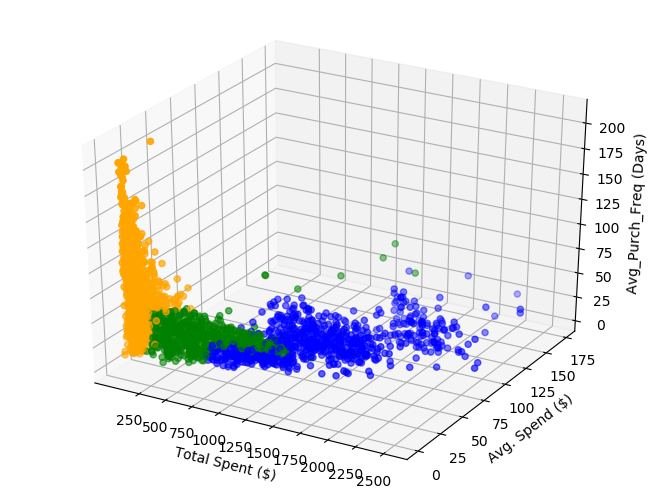

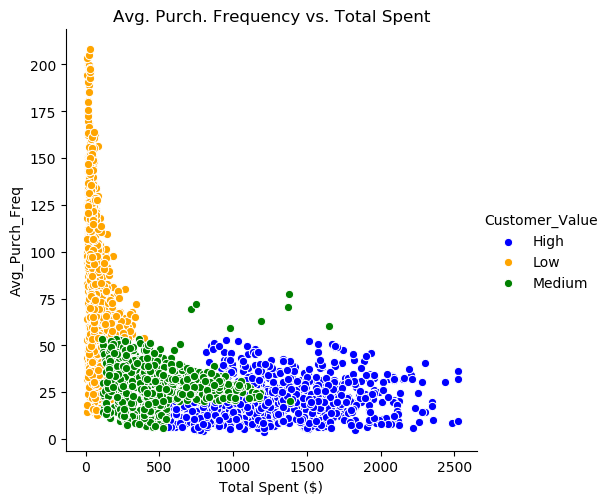

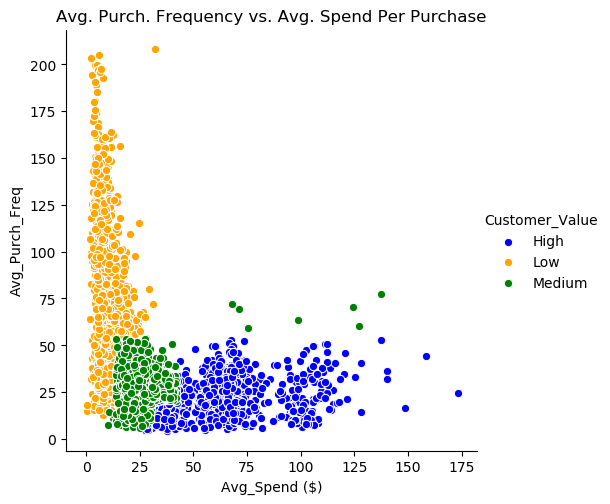

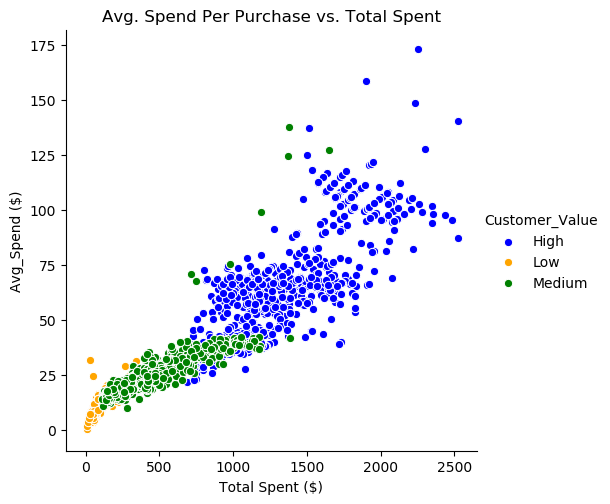

In [442]:
### Frequency vs Revenue ###
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

color = { 'High': 'blue', 'Medium': 'green', 'Low': 'orange'}

customer_clusters['colors'] = customer_clusters['Customer_Value'].replace({ 'High': 'blue', 'Medium': 'green', 'Low': 'orange'})

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(customer_clusters['Total Spent ($)'], customer_clusters['Avg_Spend ($)'], customer_clusters['Avg_Purch_Freq'],
           c=customer_clusters['colors'])
ax.set_xlabel('Total Spent ($)')
ax.set_zlabel('Avg_Purch_Freq (Days)')
ax.set_ylabel('Avg. Spend ($)')
ax.set_xticks([250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500])

sns.pairplot(x_vars=["Total Spent ($)"], y_vars=["Avg_Purch_Freq"], data=customer_clusters, hue="Customer_Value", palette=color, size=5)
plt.title('Avg. Purch. Frequency vs. Total Spent')
sns.pairplot(x_vars=["Avg_Spend ($)"], y_vars=["Avg_Purch_Freq"], data=customer_clusters, hue="Customer_Value", palette=color, size=5)
plt.title('Avg. Purch. Frequency vs. Avg. Spend Per Purchase')
sns.pairplot(x_vars=["Total Spent ($)"], y_vars=["Avg_Spend ($)"], data=customer_clusters, hue="Customer_Value", palette=color, size=5)
plt.title('Avg. Spend Per Purchase vs. Total Spent')




**Classification - 1)Predict Acceptance of one offer  2) Predict Likelihood Group (low/medium/high)**

**----------------------Imbalanced----------------------------**

0    1214
1     453
Name: Accept_One, dtype: int64


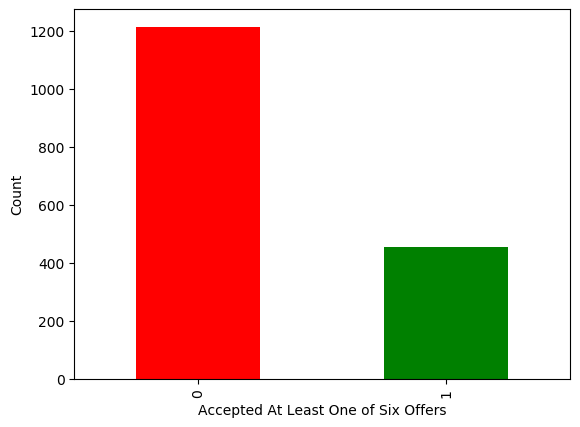

In [443]:
### Imbalanced Classification Targets ###
my_colors = ['red', 'green']

ml = ml.drop('Total Spent ($)', axis=1)
categorical = categorical.drop('Total Spent ($)', axis=1)
X = ml.values
y = marketing['Accept_One'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42, stratify=y)

new = pd.DataFrame(y_train)
new.columns = ['Accept_One']
print(new['Accept_One'].value_counts())
new['Accept_One'].value_counts().plot(kind='bar', color=my_colors)
plt.ylabel('Count')
plt.xlabel('Accepted At Least One of Six Offers')
plt.show()

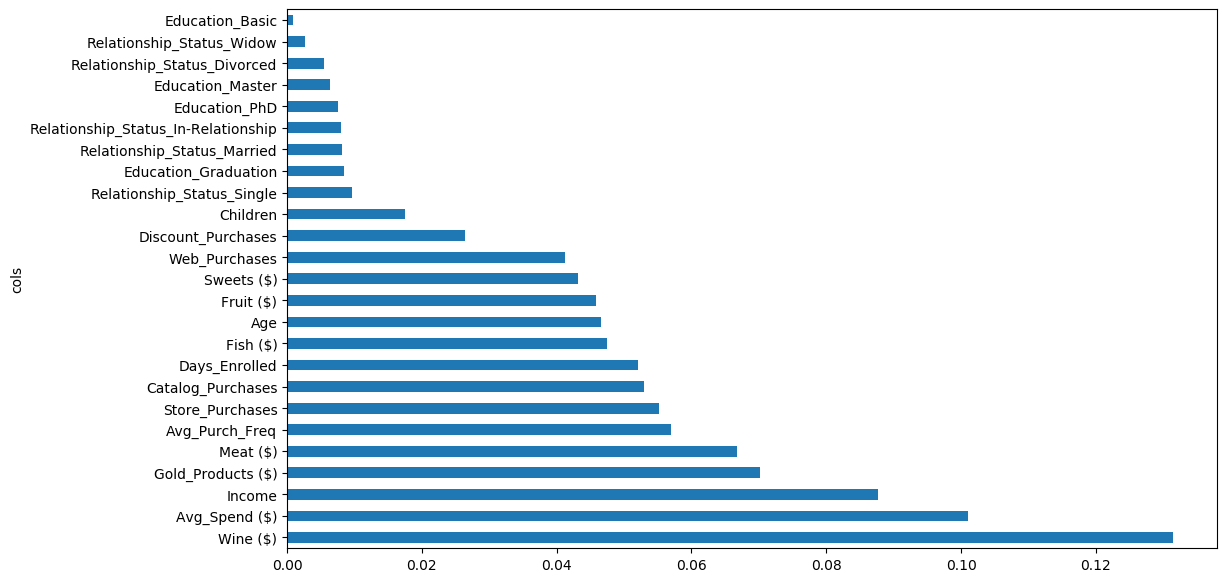


OOB Score:  0.8158368326334733

Best Params: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 600}
Training F1_Macro: 0.6520404743481146
Training Accuracy: 0.7858575469542842

Testing Accuracy: 0.7985611510791367
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       405
           1       0.68      0.48      0.57       151

    accuracy                           0.80       556
   macro avg       0.75      0.70      0.72       556
weighted avg       0.79      0.80      0.79       556

[[371  34]
 [ 78  73]]

ROC_AUC:  0.6997465456626605


In [445]:
### RandomForest ###

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

scoring = ['accuracy','f1_macro']

clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1, scoring=scoring, refit='f1_macro',
                           cv=5,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)
plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('Training F1_Macro:', np.mean(grid_search.cv_results_['mean_test_f1_macro']))
print('Training Accuracy:', np.mean(grid_search.cv_results_['mean_test_accuracy']))
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)


**Summary of XBG Hyperparameter tuning steps I took for each XGboost model**

In [480]:
### XGB hyperparameter tuning ###
from xgboost import XGBClassifier

params = {'subsample': [.8, .7]}
xgb = XGBClassifier(objective='binary:logistic', nthread=4, n_estimators=2500, learning_rate=.005, 
                    subsample=.8, colsample_bytree=.8, max_depth = 5, min_child_weight=1, gamma=.1, random_state=27)
grid_search = RandomizedSearchCV(xgb, 
                           param_distributions=params,
                           n_jobs=-1, scoring=scoring, refit='f1_macro',
                           cv=5, n_iter=50, 
                           iid=False)
grid_search.fit(X_train, y_train)
print('Training F1_Macro:', np.mean(grid_search.cv_results_['mean_test_f1_macro']))
print('Training Accuracy:', np.mean(grid_search.cv_results_['mean_test_accuracy']))
xgb = grid_search.best_estimator_
y_pred_test = xgb.predict(X_test)
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

Training F1_Macro: 0.7420692036371854
Training Accuracy: 0.810469422600582

Testing Accuracy: 0.8039568345323741
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       405
           1       0.68      0.54      0.60       151

    accuracy                           0.80       556
   macro avg       0.76      0.72      0.73       556
weighted avg       0.79      0.80      0.80       556

[[366  39]
 [ 70  81]]

ROC_AUC:  0.7200637723816531


**--------------------Undersampling----------------------------**

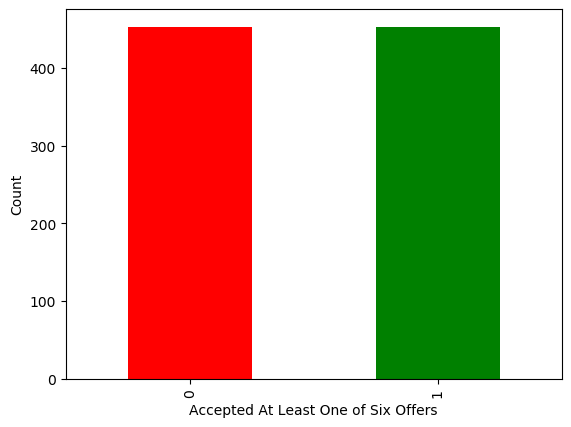

Acceptance Value Counts
1    453
0    453
dtype: int64


In [481]:
### Undersampling ###
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
acceptance = pd.Series(y_resampled)
acceptance.value_counts().reset_index(drop=True).plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.show()
print('Acceptance Value Counts')
print(acceptance.value_counts())


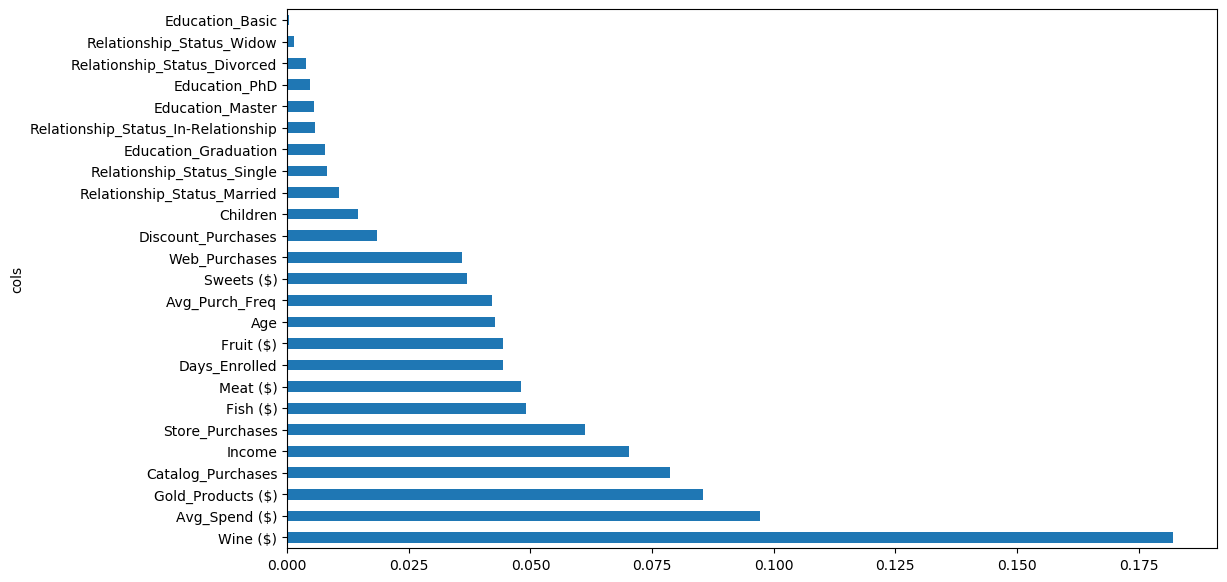


OOB Score:  0.7538631346578366

Best Params: {'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 100}
Training F1_Macro: 0.6566756272747964
Training Accuracy: 0.690462588301506

Testing Accuracy: 0.7338129496402878
              precision    recall  f1-score   support

           0       0.89      0.72      0.80       405
           1       0.51      0.76      0.61       151

    accuracy                           0.73       556
   macro avg       0.70      0.74      0.70       556
weighted avg       0.79      0.73      0.75       556

[[293 112]
 [ 36 115]]

ROC_AUC:  0.7425230970484834


In [482]:
### Random Forest Classifier Using Undersampling ###
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1, scoring=scoring, refit='f1_macro',
                           cv=4,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_resampled, y_resampled)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)
plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('Training F1_Macro:', np.mean(grid_search.cv_results_['mean_test_f1_macro']))
print('Training Accuracy:', np.mean(grid_search.cv_results_['mean_test_accuracy']))
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

In [506]:
params = {'subsample':[.8]}
xgb = XGBClassifier(objective='binary:logistic', nthread=4, n_estimators=3500, learning_rate=.005, 
                    subsample=.8, colsample_bytree=.8, min_child_weight=1, max_depth=5, gamma=0, random_state=27)
grid_search = RandomizedSearchCV(xgb, 
                           param_distributions=params,
                           n_jobs=-1, scoring=scoring, refit='f1_macro',
                           cv=4, n_iter=2,
                           iid=False)
grid_search.fit(X_resampled, y_resampled)
print('Training F1_Macro:', np.mean(grid_search.cv_results_['mean_test_f1_macro']))
print('Training Accuracy:', np.mean(grid_search.cv_results_['mean_test_accuracy']))
xgb = grid_search.best_estimator_
y_pred_test = xgb.predict(X_test)
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)


Training F1_Macro: 0.7578398363154908
Training Accuracy: 0.7582770532526005

Testing Accuracy: 0.7607913669064749
              precision    recall  f1-score   support

           0       0.90      0.76      0.82       405
           1       0.54      0.76      0.63       151

    accuracy                           0.76       556
   macro avg       0.72      0.76      0.73       556
weighted avg       0.80      0.76      0.77       556

[[308  97]
 [ 36 115]]

ROC_AUC:  0.761041615567002


**-------------------Oversampling---------------------------------**

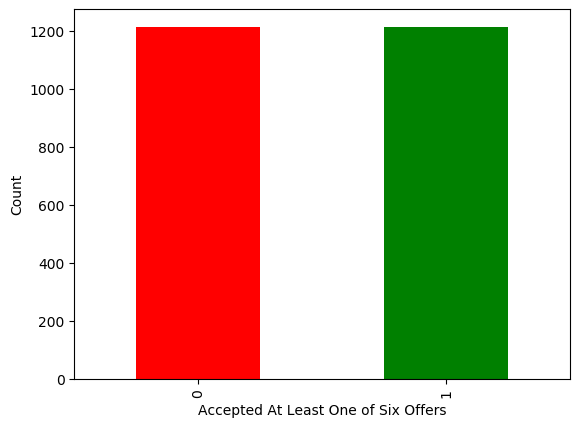

1    1214
0    1214
dtype: int64


In [507]:
### Oversampling ###
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority', n_jobs=-1, random_state=47)
X_sm, y_sm = smote.fit_resample(X_train, y_train)
acceptance = pd.Series(y_sm)
acceptance.value_counts().reset_index(drop=True).plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.show()
print(acceptance.value_counts())

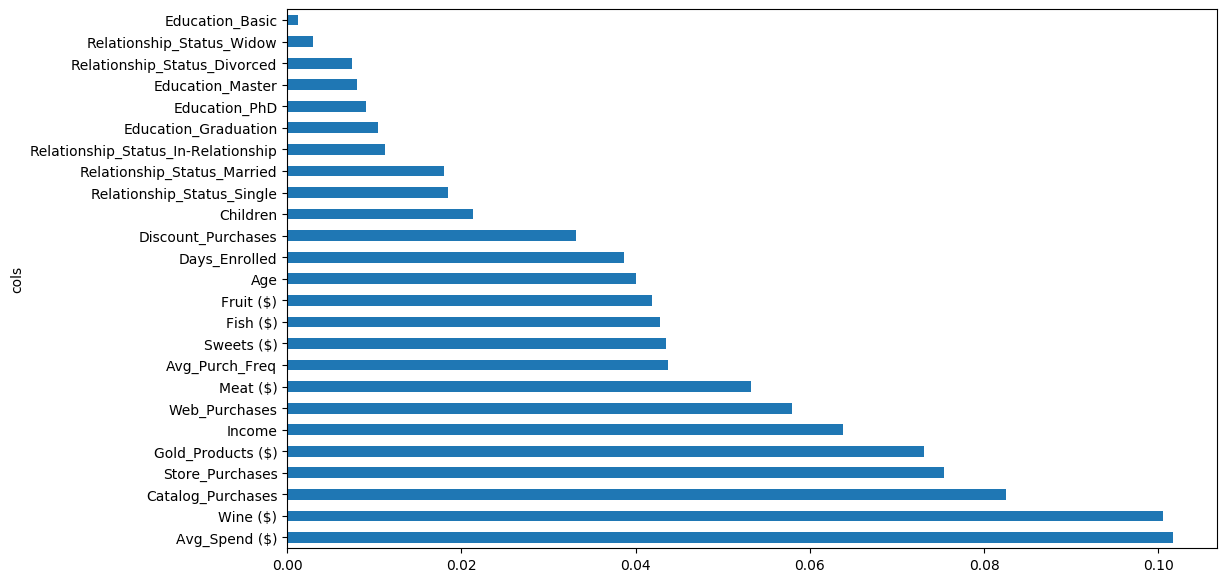


OOB Score:  0.8892092257001647

Best Params: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 600}
Training F1_Macro: 0.7352768344553278
Training Accuracy: 0.7688751087239265

Testing Accuracy: 0.7787769784172662
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       405
           1       0.59      0.61      0.60       151

    accuracy                           0.78       556
   macro avg       0.72      0.73      0.72       556
weighted avg       0.78      0.78      0.78       556

[[341  64]
 [ 59  92]]

ROC_AUC:  0.7256234159103916


In [508]:
### Random Forest Classifier Using Oversampling ###
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1, scoring=scoring, refit='f1_macro',
                           cv=6,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_sm, y_sm)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)


plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('Training F1_Macro:', np.mean(grid_search.cv_results_['mean_test_f1_macro']))
print('Training Accuracy:', np.mean(grid_search.cv_results_['mean_test_accuracy']))
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

In [532]:
params = {'subsample': [.6]}
xgb = XGBClassifier(objective='binary:logistic', nthread=4, n_estimators=11000, learning_rate=.001, 
                    subsample=0.6, colsample_bytree=.7, max_depth=9, min_child_weight=2, gamma=0, random_state=27)
grid_search = RandomizedSearchCV(xgb, 
                           param_distributions=params,
                           n_jobs=-1, scoring=scoring, refit='f1_macro',
                           cv=6, n_iter=2,
                           iid=False)
grid_search.fit(X_sm, y_sm)
print('Training F1_Macro:', np.mean(grid_search.cv_results_['mean_test_f1_macro']))
print('Training Accuracy:', np.mean(grid_search.cv_results_['mean_test_accuracy']))
xgb = grid_search.best_estimator_
y_pred_test = xgb.predict(X_test)
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)


Training F1_Macro: 0.8758715824735086
Training Accuracy: 0.8765973272204067

Testing Accuracy: 0.8039568345323741
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       405
           1       0.64      0.64      0.64       151

    accuracy                           0.80       556
   macro avg       0.75      0.75      0.75       556
weighted avg       0.80      0.80      0.80       556

[[351  54]
 [ 55  96]]

ROC_AUC:  0.7512141280353202


**-------------Hybrid Approach (Undersampling & Oversampling)----------**

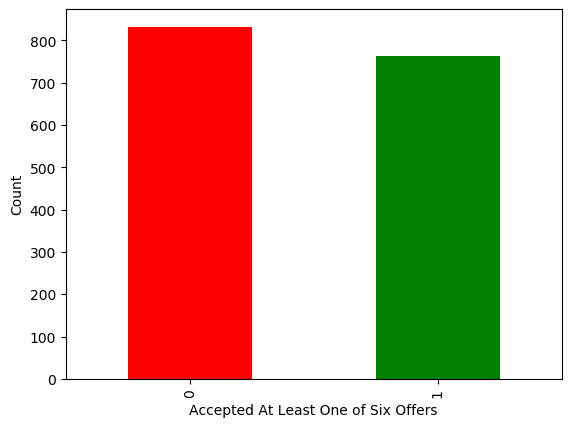

0    832
1    764
dtype: int64


In [1028]:
### Hybrid ###
over = SMOTE(sampling_strategy=.63, random_state=47)
under = RandomUnderSampler(sampling_strategy=.9175, random_state=0)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)
X_hybrid, y_hybrid = pipeline.fit_resample(X_train, y_train) 
acceptance = pd.Series(y_hybrid)
acceptance.value_counts().reset_index(drop=True).plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.show()
print(acceptance.value_counts())


In [1017]:
### .629, .9175 ###

params = {'subsample':[.9]}
xgb = XGBClassifier(objective='binary:logistic', n_estimators=3250, nthread=4, learning_rate=.0075,
                   gamma=.1, subsample=.9, colsample_bytree=.7,
                    min_child_weight=1, max_depth=9, random_state=27)
grid_search = RandomizedSearchCV(xgb, 
                           param_distributions=params,
                           n_jobs=-1, scoring=scoring, refit='f1_macro',
                           cv=5, n_iter=2,
                           iid=False)
grid_search.fit(X_hybrid, y_hybrid)
print('Training F1_Macro:', np.mean(grid_search.cv_results_['mean_test_f1_macro']))
print('Training Accuracy:', np.mean(grid_search.cv_results_['mean_test_accuracy']))
xgb = grid_search.best_estimator_
y_pred_test = xgb.predict(X_test)
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

Training F1_Macro: 0.8314553025190887
Training Accuracy: 0.8326029898858461

Testing Accuracy: 0.802158273381295
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       405
           1       0.62      0.69      0.65       151

    accuracy                           0.80       556
   macro avg       0.75      0.77      0.76       556
weighted avg       0.81      0.80      0.81       556

[[342  63]
 [ 47 104]]

ROC_AUC:  0.7665930831493745


**After classifying a customer as Accepted (1), classify their offer acceptance rate (indicates customers that are most likely to accept the offer each time it is sent out)**

513.03

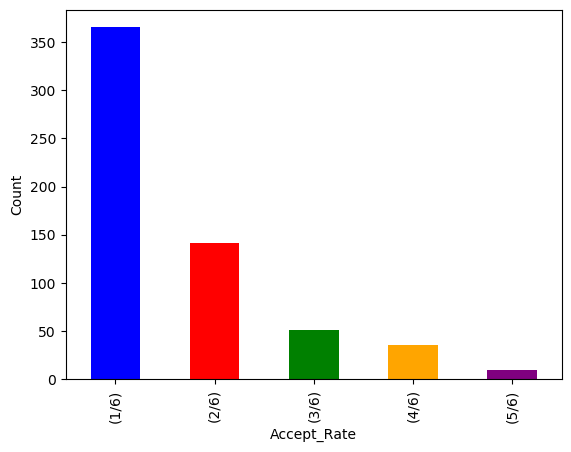

  Accept_Rate  # Customers
0       (1/6)          365
1       (2/6)          142
2       (3/6)           51
3       (4/6)           36
4       (5/6)           10


In [1086]:
### Sclicing to only included customers who accepted at least one offer ###
marketing = pd.read_csv('Data/Cust_Records.csv')
marketing_accept = marketing.loc[marketing['Accept_One'] == 1].reset_index(drop=True)

### Distribution of Those Who Accepted At Least One Offer ###
my_colors = ['blue', 'red', 'green', 'orange', 'purple']
new = marketing_accept.groupby('Accept_Rate')['Accept_One'].count().reset_index()
new.columns = ['Accept_Rate', '# Customers']
marketing_accept.groupby('Accept_Rate')['Accept_Rate'].count().plot(kind='bar', color=my_colors)
plt.xlabel('Accept_Rate')
plt.ylabel('Count')
plt.show()
print(new)


**Will Split Acceptance Rate into THREE groups "Least Likely"(1 - Accept Only 1/6), "More Likely"(2 - Accept 2/6 or 3/6), "Most Likely" (3 - Accept 4/6 or 5/6). 

In [1087]:
### Numerically Encoding the three likelihood groups ^ with Accept_Rate ###

for idx, row in marketing_accept.iterrows():
    if row['Accept_Rate'] == '(1/6)':
        marketing_accept.loc[idx, 'Accept_Rate'] = 1
    elif row['Accept_Rate'] == '(2/6)' or row['Accept_Rate'] == '(3/6)':
        marketing_accept.loc[idx, 'Accept_Rate'] = 2
    elif row['Accept_Rate'] == '(4/6)' or row['Accept_Rate'] == '(5/6)':
        marketing_accept.loc[idx, 'Accept_Rate'] = 3
    
marketing_ml_accept = marketing_accept.drop(['Accept_One', 'Accept_Rate', 'Cust_Accept (%)'], axis=1)

## Unskewing Data with Log(1 + x) transform ###
unskewed = marketing_ml_accept[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)']]
unskewed = np.log1p(unskewed)
unskewed = pd.DataFrame(unskewed)

### Scaling Numerical Features ###
scaler = StandardScaler()
numerical = scaler.fit_transform(unskewed)
numerical = pd.DataFrame(numerical)
### Numerically Encoding Categorical Features ###
categorical = pd.get_dummies(data=marketing_ml_accept, columns=['Education', 'Relationship_Status'], drop_first=False)
### Appending the categorical features to end on unskewed DF ###
ml_accept = numerical.join(categorical[['Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']], how='right')
ml_accept.columns = ['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']

1    365
2    193
3     46
Name: Accept_Rate, dtype: int64


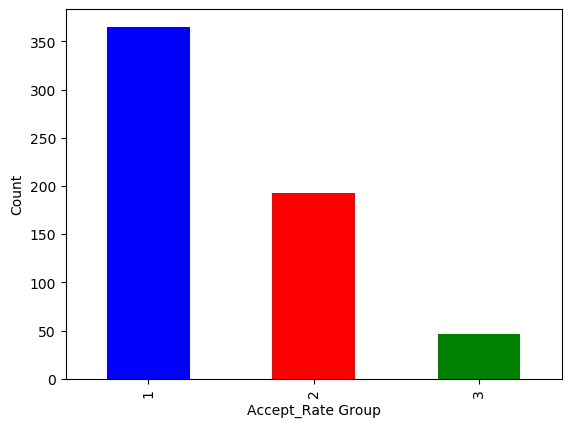

In [1088]:
X = ml_accept.values
y = marketing_accept['Accept_Rate']
new = pd.DataFrame(y)
print(new['Accept_Rate'].value_counts())
new['Accept_Rate'].value_counts().plot(kind='bar', color=my_colors)
plt.xlabel('Accept_Rate Group')
plt.ylabel('Count')
plt.show()

In [1093]:
### Nested Cross Validation - Hyperparameter Tuning ###
import collections
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

params = {'learning_rate': [.025, .01, .005, .0025],
          'n_estimators': [600, 1200, 2000, 2500, 2750, 3000, 3500],
          'subsample':[i/10.0 for i in range(6,10)],
          'colsample_bytree':[i/10.0 for i in range(6,10)],
          'max_depth':range(3,10,2),
          'min_child_weight':range(1,6,2),
           'gamma':[i/10.0 for i in range(0,5)]}

model = XGBClassifier(objective='multi:softmax',num_class=3, nthread=4, random_state=27)
dict_results = collections.defaultdict(list)

### Loop for each trial ###
NUM_TRIALS = 10
for i in range(NUM_TRIALS):
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    xgb = RandomizedSearchCV(model, 
                           param_distributions=params,
                           n_jobs=-1, scoring=scoring, refit='f1_macro',
                           cv=inner_cv, n_iter=50,
                           iid=False)
    xgb.fit(X, y)
    print('\nModel ' + str(i + 1))
    print('Best Params:', xgb.best_params_) 
    inner_f1 = np.mean(xgb.cv_results_['mean_test_f1_macro'])
    inner_acc = np.mean(xgb.cv_results_['mean_test_accuracy'])
    nested_f1 = cross_val_score(xgb, X, y, cv=outer_cv, scoring='f1_macro')
    nested_acc = cross_val_score(xgb, X, y, cv=outer_cv, scoring='accuracy')
    out_f1_mean = np.mean(nested_f1)
    out_f1_std = np.std(nested_f1)
    out_acc_mean = np.mean(nested_acc)
    out_acc_std = np.std(nested_acc)
    diff_f1 = inner_f1 - out_f1_mean
    diff_acc = inner_acc - out_acc_mean
    
    ### Creating Results DataFrame ####      
    dict_results['Model'].append(i + 1)
    dict_results['In(f1)'].append(inner_f1)
    dict_results['In(acc)'].append(inner_acc)
    dict_results['Out(f1-mean)'].append(out_f1_mean)
    dict_results['Out(f1-std)'].append(out_f1_std)
    dict_results['Out(acc_mean)'].append(out_acc_mean)
    dict_results['Out(acc_std)'].append(out_acc_std)
    dict_results['Diff(f1)'].append(diff_f1)
    dict_results['Diff(acc)'].append(diff_acc)
    
results = pd.DataFrame(dict_results)
print(results)


Model 1
Best Params: {'subsample': 0.9, 'n_estimators': 2000, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.025, 'gamma': 0.4, 'colsample_bytree': 0.7}

Model 2
Best Params: {'subsample': 0.9, 'n_estimators': 3500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}

Model 3
Best Params: {'subsample': 0.8, 'n_estimators': 2500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.005, 'gamma': 0.3, 'colsample_bytree': 0.9}

Model 4
Best Params: {'subsample': 0.7, 'n_estimators': 3000, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.025, 'gamma': 0.1, 'colsample_bytree': 0.9}

Model 5
Best Params: {'subsample': 0.8, 'n_estimators': 3000, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.005, 'gamma': 0.1, 'colsample_bytree': 0.8}

Model 6
Best Params: {'subsample': 0.9, 'n_estimators': 2000, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.0025, 'gamma': 0.2, 'colsample_bytree': 0.9}

Model 7
B

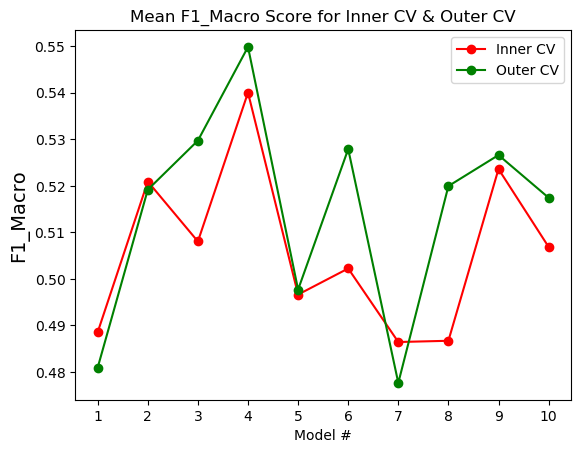

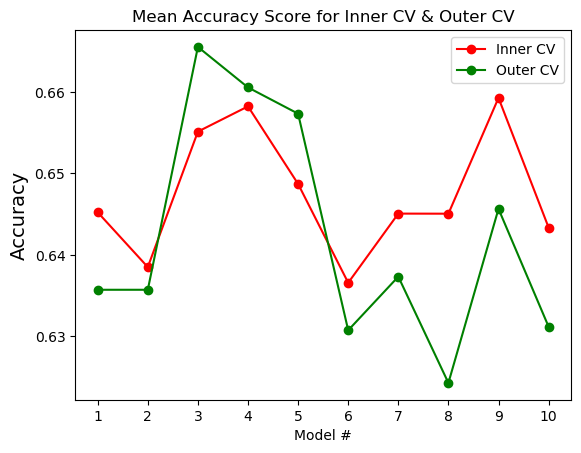

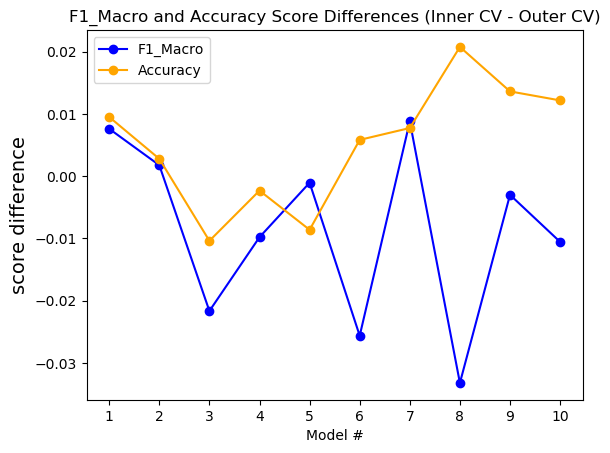

 Model  Model_Score
     4     2.352010
     9     2.274816
     2     2.264139
     5     2.251166
     3     2.229133
     6     2.198776
     8     2.194191
    10     2.168554
     7     2.138009
     1     2.120532


In [1130]:
results['Model_Score'] = results['In(f1)'] + results['In(acc)'] + results['Out(f1-mean)'] + results['Out(acc_mean)'] - results['Out(f1-std)'] - results['Out(acc_std)'] - results['Diff(f1)'] - results['Diff(acc)']
plt.plot(results['Model'], results['In(f1)'], label='Inner CV', marker='o', color='red')
plt.plot(results['Model'], results['Out(f1-mean)'], label='Outer CV', marker='o', color='green')
plt.legend()
plt.xlabel("Model #")
plt.xticks(results['Model'])
plt.ylabel("F1_Macro", fontsize="14")
plt.title('Mean F1_Macro Score for Inner CV & Outer CV')
plt.show()
plt.plot(results['Model'], results['In(acc)'], label='Inner CV', marker='o', color='red')
plt.plot(results['Model'], results['Out(acc_mean)'], label='Outer CV', marker='o', color='green')
plt.legend()
plt.xlabel("Model #")
plt.xticks(results['Model'])
plt.ylabel("Accuracy", fontsize="14")
plt.title('Mean Accuracy Score for Inner CV & Outer CV')
plt.show()
plt.plot(results['Model'], results['Diff(f1)'], label='F1_Macro', marker='o', color='blue')
plt.plot(results['Model'], results['Diff(acc)'], label='Accuracy', marker='o', color='orange')
plt.legend()
plt.xlabel("Model #")
plt.xticks(results['Model'])
plt.ylabel("score difference", fontsize="14")
plt.title('F1_Macro and Accuracy Score Differences (Inner CV - Outer CV)')
plt.show()
print(results[['Model','Model_Score']].sort_values('Model_Score', ascending=False).to_string(index=False))

Model 4
Best Params: {'subsample': 0.7, 'n_estimators': 3000, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.025, 'gamma': 0.1, 'colsample_bytree': 0.9}

In [1136]:
selected_model = results.loc[results['Model'] == 4][['Model', 'In(f1)', 'In(acc)', 'Out(f1-mean)',  'Out(f1-std)',  'Out(acc_mean)',  'Out(acc_std)',  'Diff(f1)',  'Diff(acc)']]
selected_model.columns = ['Model', 'In(f1)', 'In(acc)', 'Out(f1_mean)',  'Out(f1_std)',  'Out(acc_mean)',  'Out(acc_std)',  'Diff(f1)',  'Diff(acc)']
print(selected_model)

   Model    In(f1)  In(acc)  Out(f1_mean)  Out(f1_std)  Out(acc_mean)  Out(acc_std)  Diff(f1)  Diff(acc)
3      4  0.540029  0.65823      0.549839     0.044841       0.660555      0.023937  -0.00981  -0.002325
